In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Image Segmentation on Chest X-ray reports

**Author: Abhinay Krishna Vellala**

In this notebook, I have logged a detailed report on the steps I have implemented to train an Image Segementation model and test it on an image. I have used UNet with Batch normalization for training the model. I have used PyTorch to build my scripts. This notebook uses other scripts and imports functions. Here are the scripts used: 

1. MakeData.py - For building and loading the data. 
2. sanityChecks.py - Checks for assertion errors
3. models.py - The two UNet models (Full architecture, Pre-trained architecture)
4. evaluate.py - The evaluation metrics functions
5. tain_model.py - Helper functions for training and evaluation.

In [2]:
import os
os.chdir("/content/drive/MyDrive/UCPHTasks/Task1-Segmentation")
os.getcwd()

'/content/drive/MyDrive/UCPHTasks/Task1-Segmentation'

In [3]:
## Importing necessary Libraries 
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scripts.MakeData import make_paths_table, BuildData, Resize
from scripts.sanityChecks import check_datatable_sanity, check_image_mask_dim
from scripts.models import UNet, PretrainedUNet
from scripts.TrainUnet import train_unet, evaluate_unet
from scripts.evaluate import EvaluateImageSegmentation, evaluate_helper

## Data

There are 247 Xray report overall and each report has one mask each for Left Lung and Right Lung. I built a pipeline using PyTorch modules and data loaders in `MakeData.py` script. Here is the pipeline:

Firstly, I sorted the paths of data into a table with the path to the image and paths to its respective left lung mask and right lung mask. This is done by `make_paths_table` function. Given, path to the data and path to save an excel file, it returns and saves the table as shown below:

In [4]:
data_path = "/content/drive/MyDrive/UCPHTasks/Task1-Segmentation/data/Lung segmentation/"
save_path = "/content/drive/MyDrive/UCPHTasks/Task1-Segmentation/data/"

In [5]:
df, saved_file_path = make_paths_table(data_path, save_path)
df.head()

,images,masks_right_lung,masks_left_lung
0,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...
1,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...
2,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...
3,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...
4,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...,/content/drive/MyDrive/UCPHTasks/Task1-Segment...


A sanity check is made to verify if the images in each row match with its corresponding masks using `check_datatable_sanity` function which take the saved path and asserts if the file name is same in all the columns of each the row.

In [6]:
check_datatable_sanity(saved_file_path)

Data table is good


### A deep dive into the Data

As a next step, let's look at the data and see some of the properties. 

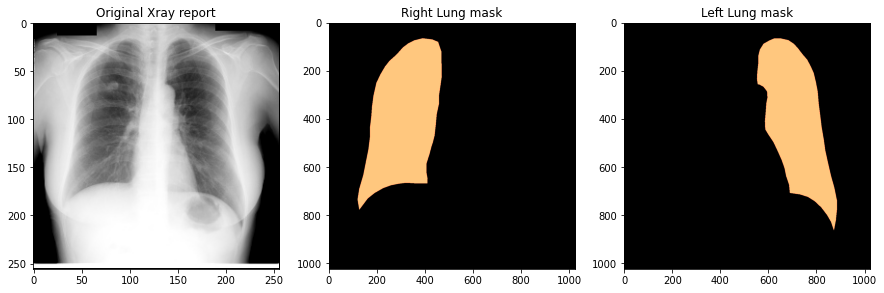

In [7]:
idx = np.random.randint(0, len(df))
img = Image.open(df['images'][idx])
right_mask = Image.open(df['masks_right_lung'][idx])
left_mask = Image.open(df['masks_left_lung'][idx])

## Plot
fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(img, cmap=plt.bone())
ax[0].set_title("Original Xray report")
ax[1].imshow(right_mask, cmap = 'copper')
ax[1].set_title("Right Lung mask")
ax[2].imshow(left_mask, cmap = 'copper')
ax[2].set_title("Left Lung mask")
plt.show()

Lets also take a look at the dimesions and pixel values of the image and masks

**Image**

In [8]:
print(f"Shape of the image: {np.array(img).shape}")
print(f"Pixel values of the image:")
print(np.unique(np.array(img)))

Shape of the image: (256, 256, 3)
Pixel values of the image:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 23

The height and width of the image are *(256x256)* and it has 3 channels. This is pretty standard image we could see. You can also see the pixel values are between range [0, 255].

**Masks**

In [9]:
# Right Mask
print(f"Shape of the right mask: {np.array(right_mask).shape}")
print(f"Pixel values of the right mask:")
print(np.unique(np.array(right_mask)))
print()
#Left Mask
print(f"Shape of the left mask: {np.array(left_mask).shape}")
print(f"Pixel values of the left mask:")
print(np.unique(np.array(left_mask)))

Shape of the right mask: (1024, 1024)
Pixel values of the right mask:
[  0 255]

Shape of the left mask: (1024, 1024)
Pixel values of the left mask:
[  0 255]


It is interesting to see that the mask has different dimesions with height and width of *(1024, 1024)*. It doesn't have a third channel and it only has values either 0 or 255. 

## Data Pipeline

In order to use the masks, it is important to firstly resize the masks according to the shape of the images. Also, since there are two masks for each image, we need to combine them into one mask. This can be done in two ways. 

1. Combining two masks and assigning lung regions as mask - Binary class Segmentation
2. Combining two masks and assigining individual label for each class - Multi Class Segmentation

We start with splitting the data for model training and evaluation

Once we choose the type of mask we wanted, apply PyTorch transofrmation and return the images and masks. The data is then loaded using DataLoader module to feed to the model. So, Here are the steps in the data pipeline after splitting the data for model training and evaluation:

- **Step 1**: For each mask, resize the dimensions.
- **Step 2**: Combine the data using any one method shown above. 
- **Step 3**: Change the pixel values from 255 to 1 or/and 2
- **Step 4**: Load the data as Dataloader object for feeding to the model

In [10]:
train, valid = train_test_split(df, test_size=0.2)
print(f"Number of Images and masks for training: {train.shape[0]}")
print(f"Number of Images and masks for validation: {valid.shape[0]}")

Number of Images and masks for training: 197
Number of Images and masks for validation: 50


In [11]:
# make a dictionary with a list of all folder paths for trainining and validation
images_folder_list = {'train': list(train['images']), 'valid': list(valid['images'])}
masks_folder_list = {'train': list(zip(train['masks_right_lung'], train['masks_left_lung'])), 
                     'valid': list(zip(valid['masks_right_lung'], valid['masks_left_lung']))}

In [12]:
# enable resize pipeline
resize_masks = torchvision.transforms.Compose([Resize((256, 256))])

This is sample to show you how the masks look in both the cases when masks are combined a binary and multi class values

**Example of the mask when class is chosen for Binary Classification**

In [13]:
sample_classType = "single"
datasets = {phase: BuildData(images_folder_list[phase],
                 masks_folder_list[phase], resize_masks, sample_classType) for phase in ['train', 'valid']}

A sanity check is made to make sure the dimesions of masks matches with the images

In [14]:
# sanity checker                 
# check_image_mask_dim(datasets)
# The time it took to run this cell was more than 10 min for the first time. 
# However when this cell was rerun it took few seconds. Commenting it for now. 
# Please uncomment this check if required.

Text(0.5, 1.0, 'Overlay of Scan and mask')

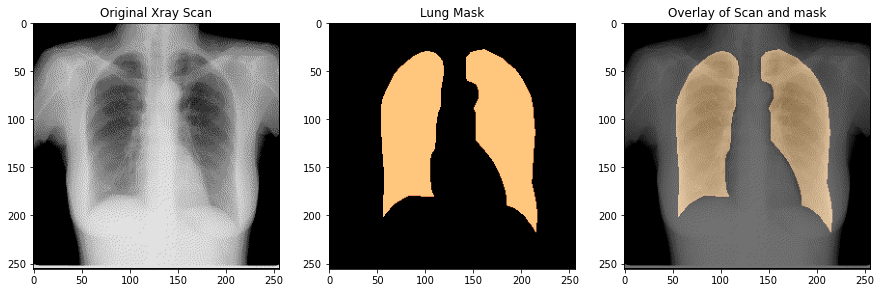

In [15]:
phase = "train"
idx = np.random.randint(0, len(datasets[phase]))
image, mask = datasets[phase][idx]
pil_image = torchvision.transforms.functional.to_pil_image(image + 0.5).convert("RGB")
pil_mask = torchvision.transforms.functional.to_pil_image(mask.float()).convert("L")
fig, ax = plt.subplots(1,3, figsize = (15,10))
ax[0].imshow(pil_image, cmap=plt.bone())
ax[0].set_title("Original Xray Scan")
ax[1].imshow(pil_mask, cmap='copper')
ax[1].set_title("Lung Mask")
ax[2].imshow(pil_image, cmap = plt.bone())
ax[2].imshow(pil_mask, cmap = 'copper', alpha=0.5)
ax[2].set_title("Overlay of Scan and mask")

In [16]:
print(f"Number of Unique Masks: {np.unique(mask)}")

Number of Unique Masks: [0 1]


**Example of the mask when class is chosen for Multi Classification**

In [17]:
sample_classType = "multi"
datasets = {phase: BuildData(images_folder_list[phase],
                 masks_folder_list[phase], resize_masks, sample_classType) for phase in ['train', 'valid']}

Text(0.5, 1.0, 'Overlay of Scan and mask')

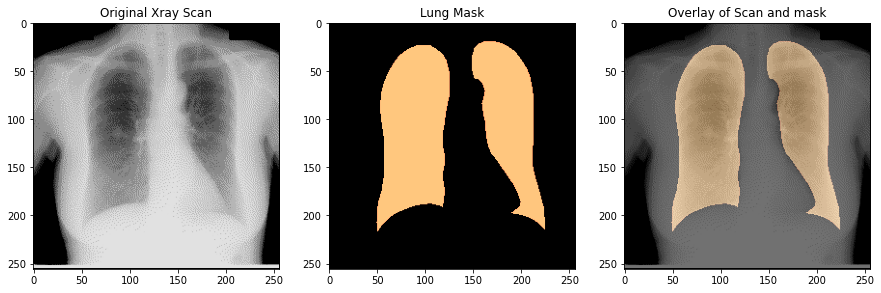

In [18]:

phase = "train"
idx = np.random.randint(0, len(datasets[phase]))
image, mask = datasets[phase][idx]
# mask[mask == 255.0] = 50
pil_image = torchvision.transforms.functional.to_pil_image(image + 0.5).convert("RGB")
pil_mask = torchvision.transforms.functional.to_pil_image(mask.float()).convert("L")
fig, ax = plt.subplots(1,3, figsize = (15,10))
ax[0].imshow(pil_image, cmap=plt.bone())
ax[0].set_title("Original Xray Scan")
ax[1].imshow(pil_mask, cmap='copper')
ax[1].set_title("Lung Mask")
ax[2].imshow(pil_image, cmap = plt.bone())
ax[2].imshow(pil_mask, cmap = 'copper', alpha=0.5)
ax[2].set_title("Overlay of Scan and mask")

In [19]:
print(f"Number of Unique Masks: {np.unique(mask)}")

Number of Unique Masks: [0 1 2]


## Model

A Unet model with VGG11 pretrained weights are used and the weights are then finetuned with the model. I have used the [github](https://github.com/IlliaOvcharenko/lung-segmentation/blob/master/src/models.py) to import the Unet architecture in `models.py` file. 

I initiallly trained multi class segmentation and have also done binary class segmentation and evaluated the performance. 

### Multi Class segmentation

Data has been loaded just like above with and the sample class type is chosen to be "multi" for multi class segmentation. The batch size is chosen to be 4 to support the compute speed and then number of classes are 3 which includes two lungs and background. The batch normalization is enabled to for UNet. 

The pre-trained weights of VGG11 are used for the encoder convolution layers and are then fined tuned. 

The optimizer used here is Adam and the learning rate is chosen to be 1e-5.

The model weights are saved after 5,10,20,30,50 epochs to compare the evaluation metrics and detemine the best place to stop training. 

In [20]:
sample_classType = "multi"
datasets = {phase: BuildData(images_folder_list[phase],
                 masks_folder_list[phase], resize_masks, sample_classType) for phase in ['train', 'valid']}

In [21]:
batch_size = 4
dataloaders = {phase: torch.utils.data.DataLoader(datasets[phase], batch_size=batch_size) 
               for phase in ["train", "valid"]}

In [22]:
num_classes = 3
batch_norm = True
upscale_mode="bilinear"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
model = PretrainedUNet(in_channels=1, out_channels=num_classes, batch_norm=batch_norm, 
                       upscale_mode=upscale_mode)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [24]:
model_ckpts = [1, 5, 10, 20, 50]
epochs = 51
save_models_path = 'model_ckpts/'

**Evaluation Metrics**

The default loss optimization is done by Categorical cross entroy while training by adding softmax layer at the end and extracting the maximum probability. However, I have also implemented other metrics to evalutate the results. They are:

1. Dice Score
2. Intersection over Union
3. Accuracy
4. Hausdorff distance

I have the evaluation metrics built and imported from my personal [github repo](https://github.com/abhi-vellala/EvaluateImageSegmentation).

In [25]:
train_loss_dict = {'loss':[], 'dice':[], 'iou':[], 'accuracy':[], 'hausdorf':[]}
validation_loss_dict = {'loss':[], 'dice':[], 'iou':[], 'accuracy':[], 'hausdorf':[]}
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    train_loss = train_unet(dataloaders, model, device, optimizer)
    train_loss = evaluate_helper(train_loss)
    for key, value in train_loss.items():
      train_loss_dict[key].append(value) 
    # print(train_loss)
    validation_loss = evaluate_unet(dataloaders, model, device)
    validation_loss = evaluate_helper(validation_loss)
    for key, value in validation_loss.items():
      validation_loss_dict[key].append(value)
    # print(validation_loss)
    if epoch+1 in model_ckpts:
      model_name = f'model_{epoch+1}_epochs_trained.pt'
      torch.save(model.state_dict(), os.path.join(save_models_path + model_name))
      print(f"model saved after {epoch+1} epochs")

Epoch: 1


100%|██████████| 50/50 [00:15<00:00,  3.32it/s, loss=0.235]


model saved after 1 epochs
Epoch: 2


100%|██████████| 50/50 [00:11<00:00,  4.50it/s, loss=0.148]


Epoch: 3


100%|██████████| 50/50 [00:11<00:00,  4.42it/s, loss=0.104]


Epoch: 4


100%|██████████| 50/50 [00:11<00:00,  4.53it/s, loss=0.0756]


Epoch: 5


100%|██████████| 50/50 [00:10<00:00,  4.59it/s, loss=0.0614]


model saved after 5 epochs
Epoch: 6


100%|██████████| 50/50 [00:11<00:00,  4.50it/s, loss=0.0539]


Epoch: 7


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0449]


Epoch: 8


100%|██████████| 50/50 [00:11<00:00,  4.47it/s, loss=0.0429]


Epoch: 9


100%|██████████| 50/50 [00:11<00:00,  4.47it/s, loss=0.036]


Epoch: 10


100%|██████████| 50/50 [00:11<00:00,  4.49it/s, loss=0.0322]


model saved after 10 epochs
Epoch: 11


100%|██████████| 50/50 [00:11<00:00,  4.44it/s, loss=0.0302]


Epoch: 12


100%|██████████| 50/50 [00:11<00:00,  4.40it/s, loss=0.0279]


Epoch: 13


100%|██████████| 50/50 [00:11<00:00,  4.49it/s, loss=0.0266]


Epoch: 14


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0263]


Epoch: 15


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0305]


Epoch: 16


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.0228]


Epoch: 17


100%|██████████| 50/50 [00:11<00:00,  4.48it/s, loss=0.0209]


Epoch: 18


100%|██████████| 50/50 [00:11<00:00,  4.53it/s, loss=0.0212]


Epoch: 19


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0194]


Epoch: 20


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0193]


model saved after 20 epochs
Epoch: 21


100%|██████████| 50/50 [00:11<00:00,  4.49it/s, loss=0.034]


Epoch: 22


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0296]


Epoch: 23


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0249]


Epoch: 24


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0253]


Epoch: 25


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0238]


Epoch: 26


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.0222]


Epoch: 27


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0209]


Epoch: 28


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0194]


Epoch: 29


100%|██████████| 50/50 [00:10<00:00,  4.58it/s, loss=0.017]


Epoch: 30


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.017]


Epoch: 31


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0156]


Epoch: 32


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.0155]


Epoch: 33


100%|██████████| 50/50 [00:11<00:00,  4.50it/s, loss=0.0151]


Epoch: 34


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.016]


Epoch: 35


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0154]


Epoch: 36


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0162]


Epoch: 37


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0155]


Epoch: 38


100%|██████████| 50/50 [00:11<00:00,  4.53it/s, loss=0.0154]


Epoch: 39


100%|██████████| 50/50 [00:11<00:00,  4.46it/s, loss=0.0142]


Epoch: 40


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.0136]


Epoch: 41


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.0127]


Epoch: 42


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0182]


Epoch: 43


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0174]


Epoch: 44


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0141]


Epoch: 45


100%|██████████| 50/50 [00:11<00:00,  4.50it/s, loss=0.013]


Epoch: 46


100%|██████████| 50/50 [00:11<00:00,  4.49it/s, loss=0.0119]


Epoch: 47


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0126]


Epoch: 48


100%|██████████| 50/50 [00:11<00:00,  4.47it/s, loss=0.0117]


Epoch: 49


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.0127]


Epoch: 50


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0126]


model saved after 50 epochs
Epoch: 51


100%|██████████| 50/50 [00:11<00:00,  4.46it/s, loss=0.0171]


In [26]:
epoch

50

## Evaluation and Ineference

The evaluation is done by taking the "validation" data with the ground truth masks available and extracting the metrics.

The metrics are calcualted for each image with it corresponding ground truth mask. The ground truth mask is compared with the prediction. The average of metric for the whole batch is then extracted for each epoch. This is done in both training and evalautation phases.

Note: A correction has been made for the Hausdorff distance by normalizing the result. It is still not perfect but the other metrics are perfectly showing the results. 

In [27]:
min_val = min(train_loss_dict['hausdorf'])
max_val = max(train_loss_dict['hausdorf'])
train_loss_dict['hausdorf'] = list(map(lambda x: 1- (x-min_val)/(max_val - min_val), train_loss_dict['hausdorf']))

min_val = min(validation_loss_dict['hausdorf'])
max_val = max(validation_loss_dict['hausdorf'])
validation_loss_dict['hausdorf'] = list(map(lambda x: 1- (x-min_val)/(max_val - min_val), 
                                            validation_loss_dict['hausdorf']))

The extracted metrics are plotted along with the each epoch. 

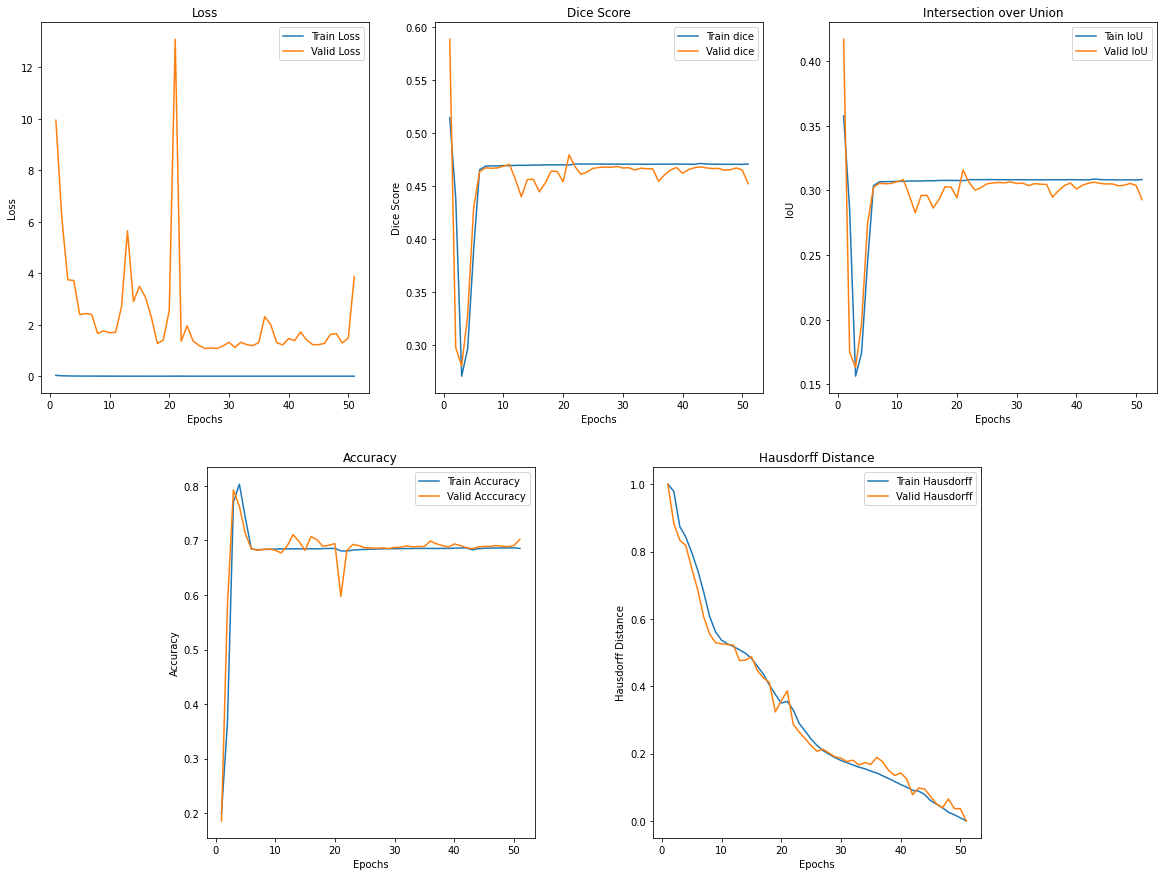

In [28]:
fig,axs = plt.subplots(2,3, figsize=(20,15))
axs[1][2].set_visible(False)

axs[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axs[1][1].set_position([0.55, 0.125, 0.228, 0.343])

axs[0,0].plot(range(1,epochs+1), train_loss_dict['loss'], label='Train Loss')
axs[0,0].plot(range(1,epochs+1), validation_loss_dict['loss'], label='Valid Loss')
axs[0,0].set_title('Loss')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].legend()
axs[0,1].plot(range(1,epochs+1), train_loss_dict['dice'], label='Train dice')
axs[0,1].plot(range(1,epochs+1), validation_loss_dict['dice'], label='Valid dice')
axs[0,1].set_title('Dice Score')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Dice Score')
axs[0,1].legend()
axs[0,2].plot(range(1,epochs+1), train_loss_dict['iou'], label='Tain IoU')
axs[0,2].plot(range(1,epochs+1), validation_loss_dict['iou'], label='Valid IoU')
axs[0,2].set_title('Intersection over Union')
axs[0,2].set_xlabel('Epochs')
axs[0,2].set_ylabel('IoU')
axs[0,2].legend()
axs[1,0].plot(range(1,epochs+1), train_loss_dict['accuracy'], label='Train Accuracy')
axs[1,0].plot(range(1,epochs+1), validation_loss_dict['accuracy'], label='Valid Acccuracy')
axs[1,0].set_title('Accuracy')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].legend()
axs[1,1].plot(range(1,epochs+1), train_loss_dict['hausdorf'], label='Train Hausdorff')
axs[1,1].plot(range(1,epochs+1), validation_loss_dict['hausdorf'], label='Valid Hausdorff')
axs[1,1].set_title('Hausdorff Distance')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Hausdorff Distance')
axs[1,1].legend()

The plot shows the gradual optimization of cross entropy loss and has significantly improved the accuracy and IoU. The dice is also has been imporved. 

In [29]:
os.getcwd()

'/content/drive/MyDrive/UCPHTasks/Task1-Segmentation'

Saving the evaluation metrics to a table

In [30]:
train_metrics_multi = pd.DataFrame(columns=['loss', 'dice', 'accuracy', 'iou', 'hausdorf'])
train_metrics_multi['loss'] = train_loss_dict['loss']
train_metrics_multi['dice'] = train_loss_dict['dice']
train_metrics_multi['accuracy'] = train_loss_dict['accuracy']
train_metrics_multi['iou'] = train_loss_dict['iou']
train_metrics_multi['hausdorf'] = train_loss_dict['hausdorf']

valid_metrics_multi = pd.DataFrame(columns=['loss', 'dice', 'accuracy', 'iou', 'hausdorf'])
valid_metrics_multi['loss'] = validation_loss_dict['loss']
valid_metrics_multi['dice'] = validation_loss_dict['dice']
valid_metrics_multi['accuracy'] = validation_loss_dict['accuracy']
valid_metrics_multi['iou'] = validation_loss_dict['iou']
valid_metrics_multi['hausdorf'] = validation_loss_dict['hausdorf']


train_metrics_multi.to_excel("./eval_tables/train_metrics_multi.xlsx", index=False)
valid_metrics_multi.to_excel("./eval_tables/valid_metrics_multi.xlsx", index=False)

#### Extracting mask predictions and plots

In this section, I have used the same validation images and extracted the mask predictions. The predictions are then plotted to compare with the ground truth masks. This is done for several epochs.

In [31]:
# pred_mask.shape, mask.shape,
image.size(), mask.size()

(torch.Size([1, 256, 256]), torch.Size([256, 256]))

<Figure size 1080x576 with 0 Axes>

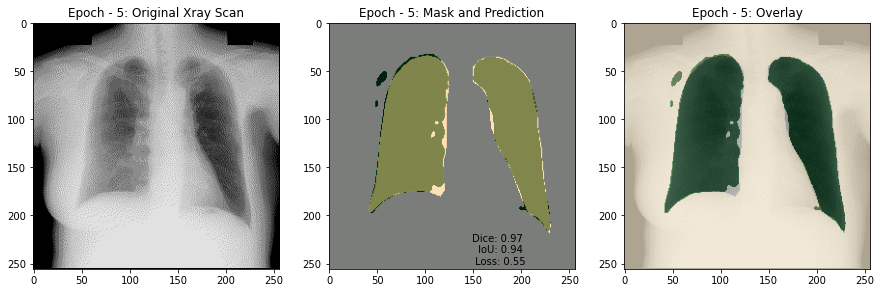

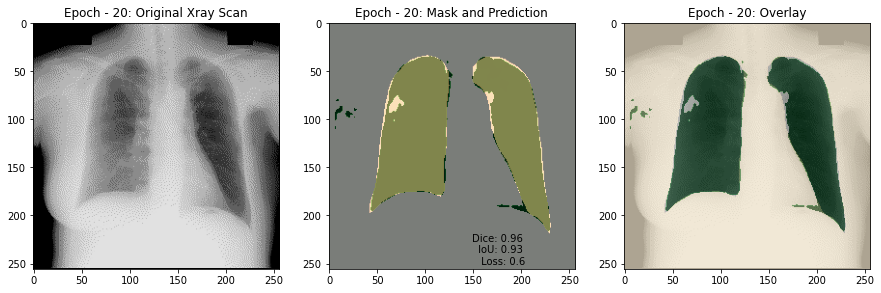

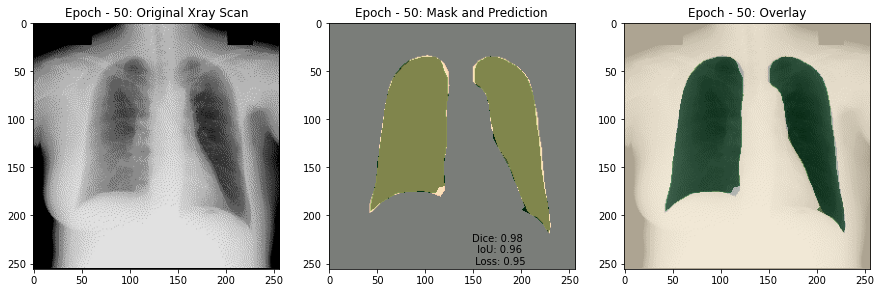

In [55]:
# idx = 22
save_models_path = 'model_ckpts/'
idx = np.random.randint(0, len(datasets["valid"]))
dataloaders = torch.utils.data.DataLoader(datasets['valid'][idx], batch_size=1)

image_mask = {i: load for i, load in enumerate(iter(dataloaders))}
image, mask = image_mask[0], image_mask[1]

plt.figure(figsize=(15, 8))
epochs = [5, 20, 50]

for epoch in epochs:
    image = image.to(device)
    mask = mask.to(device)
    model_name = f'model_{epoch}_epochs_trained.pt'
    model = PretrainedUNet(1,3,True)
    model.load_state_dict(torch.load(save_models_path + model_name, 
                                    map_location=torch.device("cpu")))
    model.to(device)
    model.eval()

    with torch.no_grad():
        pred_mask = model(image)
        softmax = torch.nn.functional.log_softmax(pred_mask, dim=1)
        v_loss = torch.nn.functional.nll_loss(softmax, mask).item()
        pred_mask = torch.argmax(softmax, dim=1)

        image = image.cpu()
        pred_mask = pred_mask.cpu()
        mask = mask.cpu()

        gt = np.array(mask, dtype=int)
        pred = np.array(pred_mask, dtype=int)

        pil_image = torchvision.transforms.functional.to_pil_image(image[0] + 0.5).convert("RGB")
        pil_mask = torchvision.transforms.functional.to_pil_image(mask.float()).convert("L")
        pil_pred_mask = torchvision.transforms.functional.to_pil_image(pred_mask.float()).convert("L")
        fig, ax = plt.subplots(1,3, figsize=(15,8))
        ax[0].imshow(pil_image, cmap=plt.bone())
        ax[0].set_title(f"Epoch - {epoch}: Original Xray Scan")
        ax[1].imshow(pil_mask, cmap='copper')
        ax[1].imshow(pil_pred_mask, cmap='Greens', alpha=0.5)
        ax[1].set_title(f"Epoch - {epoch}: Mask and Prediction")
        ax[2].imshow(pil_image, cmap = plt.bone())
        ax[2].imshow(pil_mask, cmap = 'copper_r', alpha=0.4)
        ax[2].imshow(pil_pred_mask, cmap='Greens', alpha=0.5)
        ax[2].set_title(f"Epoch - {epoch}: Overlay")
        evaluate = EvaluateImageSegmentation(gt, pred)
        scores_text1 = f"Dice: {round(evaluate.dice(),2)} \n IoU: {round(evaluate.IoU(),2)} \n"
        scores_text2 = f" Loss: {round(v_loss,2)}" # Accuracy:{round(evaluate.accuracy(),2)}
        ax[1].text(0.80, 0.01, scores_text1 + scores_text2,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1].transAxes,
        color='black', fontsize=10)


From the plot you could see the predictions are good after 5 epochs. The predictions gradually imporved and after 30 epochs, we got the mask that perfectly fits with the ground truth. 

Please note that the left lung and the right lung are two different classes and I have a color code for each class. However, the color code is not working on google colab. So, I have keep same color for both the masks. You could see the two different classes from below:

In [33]:
torch.unique(pred_mask)

tensor([0, 1, 2])

## Test Image

The models are then tested on the Gaze example Xray report and here are the results. 

In [34]:
test_image_path = "/content/drive/MyDrive/UCPHTasks/Task1-Segmentation/data/test.png"
test_img = Image.open(test_image_path).convert("P")
test_img = torchvision.transforms.functional.to_tensor(test_img) - 0.5

<Figure size 1080x576 with 0 Axes>

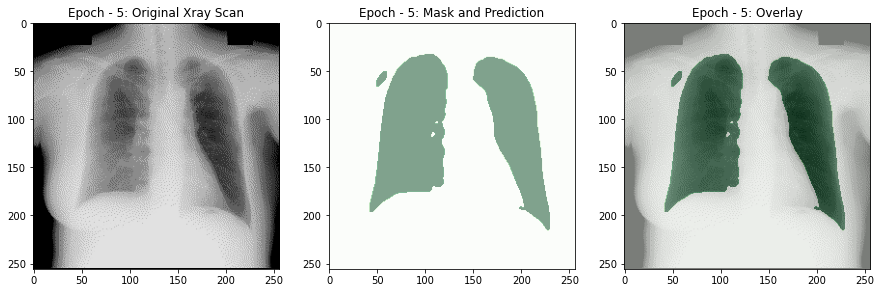

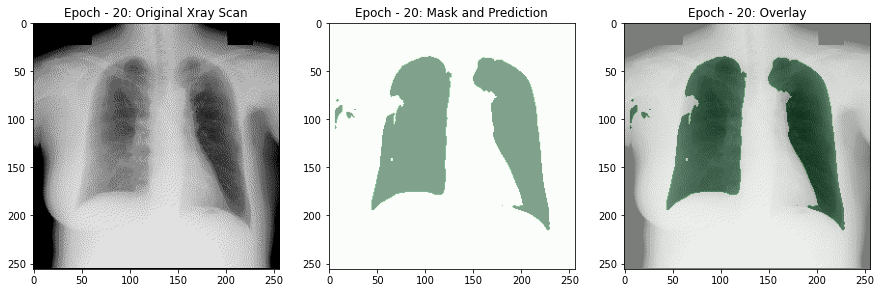

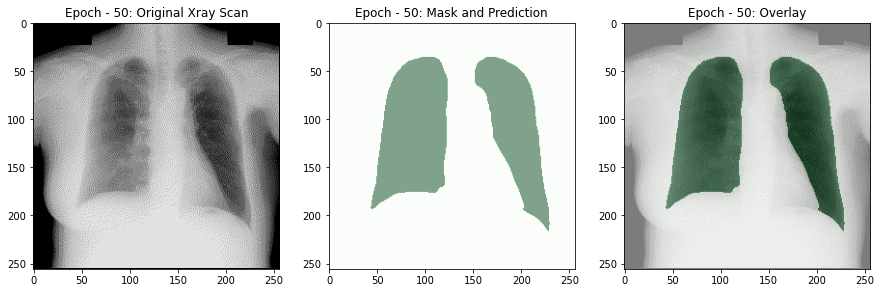

In [59]:
# # idx = 22
save_models_path = 'model_ckpts/'
plt.figure(figsize=(15, 8))
epochs = [5, 20, 50]

for epoch in epochs:
    image = image.to(device)
    mask = mask.to(device)
    model_name = f'model_{epoch}_epochs_trained.pt'
    model = PretrainedUNet(1,3,True, 'bilinear')
    model.load_state_dict(torch.load(save_models_path + model_name, 
                                    map_location=torch.device("cpu")))
    model.to(device)
    model.eval()

    with torch.no_grad():
        pred_mask = model(image)
        softmax = torch.nn.functional.log_softmax(pred_mask, dim=1)
        v_loss = torch.nn.functional.nll_loss(softmax, mask).item()
        pred_mask = torch.argmax(softmax, dim=1)

        image = image.cpu()
        pred_mask = pred_mask.cpu()

        pil_image = torchvision.transforms.functional.to_pil_image(image[0] + 0.5).convert("RGB")
        pil_pred_mask = torchvision.transforms.functional.to_pil_image(pred_mask.float()).convert("L")
        fig, ax = plt.subplots(1,3, figsize=(15,8))
        ax[0].imshow(pil_image, cmap=plt.bone())
        ax[0].set_title(f"Epoch - {epoch}: Original Xray Scan")
        ax[1].imshow(pil_pred_mask, cmap='Greens', alpha=0.5)
        ax[1].set_title(f"Epoch - {epoch}: Mask and Prediction")
        ax[2].imshow(pil_image, cmap = plt.bone())
        ax[2].imshow(pil_pred_mask, cmap='Greens', alpha=0.5)
        ax[2].set_title(f"Epoch - {epoch}: Overlay")
      


The predicted mask perfectly aligns with the lung and it proves that the model did well. 

Please note, the best way to save the model is based on the logic where we get the lowest loss. Although the validation loss at 50th epoch is not the lowest. However, colab is rewriting the file it finds best loss than previous and the runtime is getting higher because of writing to Drive at every iteration. So, I have decided to save models as checkpoints at certain epochs. 

### Binary Class segmentation

The same pipeline is implemented by taking both right and left masks as a single category and background as other category. This is a Binary class segmentation. 

In [36]:
sample_classType = "single"
datasets = {phase: BuildData(images_folder_list[phase],
                 masks_folder_list[phase], resize_masks, sample_classType) for phase in ['train', 'valid']}

In [37]:
phase = "train"
idx = np.random.randint(0, len(datasets[phase]))
image, mask = datasets[phase][idx]
print(torch.unique(mask))

tensor([0, 1])


As you can see there are only two unique values in the mask, 0 and 1. 0 represents the background and 1 represents the lung mask. 

In [38]:
batch_size = 4
dataloaders = {phase: torch.utils.data.DataLoader(datasets[phase], batch_size=batch_size) 
               for phase in ["train", "valid"]}

In [39]:
num_classes = 2
batch_norm = True
upscale_mode="bilinear"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


I'm not changing the final layer from softmax to sigmoid as softmax is the generalization of sigmoid and it should work for binary classes as well. 

In [40]:
model = PretrainedUNet(in_channels=1, out_channels=num_classes, batch_norm=batch_norm, 
                       upscale_mode=upscale_mode)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [41]:
model_ckpts = [1, 5, 10, 20, 50]
epochs = 51
save_models_path = 'model_ckpts_binary/'

Training the model

In [42]:
train_loss_dict = {'loss':[], 'dice':[], 'iou':[], 'accuracy':[], 'hausdorf':[]}
validation_loss_dict = {'loss':[], 'dice':[], 'iou':[], 'accuracy':[], 'hausdorf':[]}
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    train_loss = train_unet(dataloaders, model, device, optimizer)
    train_loss = evaluate_helper(train_loss)
    for key, value in train_loss.items():
      train_loss_dict[key].append(value) 
    # print(train_loss)
    validation_loss = evaluate_unet(dataloaders, model, device)
    validation_loss = evaluate_helper(validation_loss)
    for key, value in validation_loss.items():
      validation_loss_dict[key].append(value)
    # print(validation_loss)
    if epoch+1 in model_ckpts:
      model_name = f'model_{epoch+1}_epochs_trained.pt'
      torch.save(model.state_dict(), os.path.join(save_models_path + model_name))
      print(f"model saved after {epoch+1} epochs")

Epoch: 1


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.113]


model saved after 1 epochs
Epoch: 2


100%|██████████| 50/50 [00:11<00:00,  4.53it/s, loss=0.0799]


Epoch: 3


100%|██████████| 50/50 [00:10<00:00,  4.58it/s, loss=0.0591]


Epoch: 4


100%|██████████| 50/50 [00:10<00:00,  4.61it/s, loss=0.0467]


Epoch: 5


100%|██████████| 50/50 [00:10<00:00,  4.62it/s, loss=0.0407]


model saved after 5 epochs
Epoch: 6


100%|██████████| 50/50 [00:11<00:00,  4.53it/s, loss=0.0363]


Epoch: 7


100%|██████████| 50/50 [00:10<00:00,  4.60it/s, loss=0.0329]


Epoch: 8


100%|██████████| 50/50 [00:10<00:00,  4.57it/s, loss=0.0287]


Epoch: 9


100%|██████████| 50/50 [00:10<00:00,  4.58it/s, loss=0.0273]


Epoch: 10


100%|██████████| 50/50 [00:10<00:00,  4.59it/s, loss=0.0273]


model saved after 10 epochs
Epoch: 11


100%|██████████| 50/50 [00:11<00:00,  4.53it/s, loss=0.027]


Epoch: 12


100%|██████████| 50/50 [00:11<00:00,  4.52it/s, loss=0.0262]


Epoch: 13


100%|██████████| 50/50 [00:10<00:00,  4.60it/s, loss=0.0236]


Epoch: 14


100%|██████████| 50/50 [00:10<00:00,  4.61it/s, loss=0.0238]


Epoch: 15


100%|██████████| 50/50 [00:10<00:00,  4.60it/s, loss=0.0235]


Epoch: 16


100%|██████████| 50/50 [00:10<00:00,  4.59it/s, loss=0.0213]


Epoch: 17


100%|██████████| 50/50 [00:10<00:00,  4.60it/s, loss=0.0206]


Epoch: 18


100%|██████████| 50/50 [00:10<00:00,  4.61it/s, loss=0.0184]


Epoch: 19


100%|██████████| 50/50 [00:10<00:00,  4.59it/s, loss=0.0197]


Epoch: 20


100%|██████████| 50/50 [00:10<00:00,  4.60it/s, loss=0.0201]


model saved after 20 epochs
Epoch: 21


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.037]


Epoch: 22


100%|██████████| 50/50 [00:10<00:00,  4.63it/s, loss=0.0317]


Epoch: 23


100%|██████████| 50/50 [00:10<00:00,  4.59it/s, loss=0.0248]


Epoch: 24


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0263]


Epoch: 25


100%|██████████| 50/50 [00:11<00:00,  4.54it/s, loss=0.0225]


Epoch: 26


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.0215]


Epoch: 27


100%|██████████| 50/50 [00:10<00:00,  4.59it/s, loss=0.0205]


Epoch: 28


100%|██████████| 50/50 [00:11<00:00,  4.52it/s, loss=0.0196]


Epoch: 29


100%|██████████| 50/50 [00:10<00:00,  4.60it/s, loss=0.0173]


Epoch: 30


100%|██████████| 50/50 [00:11<00:00,  4.46it/s, loss=0.0177]


Epoch: 31


100%|██████████| 50/50 [00:11<00:00,  4.55it/s, loss=0.0171]


Epoch: 32


100%|██████████| 50/50 [00:10<00:00,  4.58it/s, loss=0.0157]


Epoch: 33


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.0152]


Epoch: 34


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.0168]


Epoch: 35


100%|██████████| 50/50 [00:12<00:00,  3.96it/s, loss=0.0155]


Epoch: 36


100%|██████████| 50/50 [00:11<00:00,  4.51it/s, loss=0.0161]


Epoch: 37


100%|██████████| 50/50 [00:10<00:00,  4.57it/s, loss=0.0158]


Epoch: 38


100%|██████████| 50/50 [00:10<00:00,  4.56it/s, loss=0.0158]


Epoch: 39


100%|██████████| 50/50 [00:11<00:00,  4.53it/s, loss=0.0149]


Epoch: 40


100%|██████████| 50/50 [00:10<00:00,  4.55it/s, loss=0.022]


Epoch: 41


100%|██████████| 50/50 [00:10<00:00,  4.59it/s, loss=0.0264]


Epoch: 42


100%|██████████| 50/50 [00:11<00:00,  4.42it/s, loss=0.0239]


Epoch: 43


100%|██████████| 50/50 [00:11<00:00,  4.52it/s, loss=0.0178]


Epoch: 44


100%|██████████| 50/50 [00:10<00:00,  4.60it/s, loss=0.0168]


Epoch: 45


100%|██████████| 50/50 [00:10<00:00,  4.59it/s, loss=0.0146]


Epoch: 46


100%|██████████| 50/50 [00:10<00:00,  4.60it/s, loss=0.0139]


Epoch: 47


100%|██████████| 50/50 [00:10<00:00,  4.62it/s, loss=0.0133]


Epoch: 48


100%|██████████| 50/50 [00:10<00:00,  4.59it/s, loss=0.0137]


Epoch: 49


100%|██████████| 50/50 [00:10<00:00,  4.61it/s, loss=0.0161]


Epoch: 50


100%|██████████| 50/50 [00:10<00:00,  4.61it/s, loss=0.0127]


model saved after 50 epochs
Epoch: 51


100%|██████████| 50/50 [00:11<00:00,  4.53it/s, loss=0.0123]


In [43]:
epoch

50

## Evaluation and Ineference

Just like mult class classification, I have made created the evaluation metrics and here are the results

In [44]:
min_val = min(train_loss_dict['hausdorf'])
max_val = max(train_loss_dict['hausdorf'])
train_loss_dict['hausdorf'] = list(map(lambda x: 1- (x-min_val)/(max_val - min_val), train_loss_dict['hausdorf']))

min_val = min(validation_loss_dict['hausdorf'])
max_val = max(validation_loss_dict['hausdorf'])
validation_loss_dict['hausdorf'] = list(map(lambda x: 1- (x-min_val)/(max_val - min_val), 
                                            validation_loss_dict['hausdorf']))

The extracted metrics are plotted along with the each epoch. 

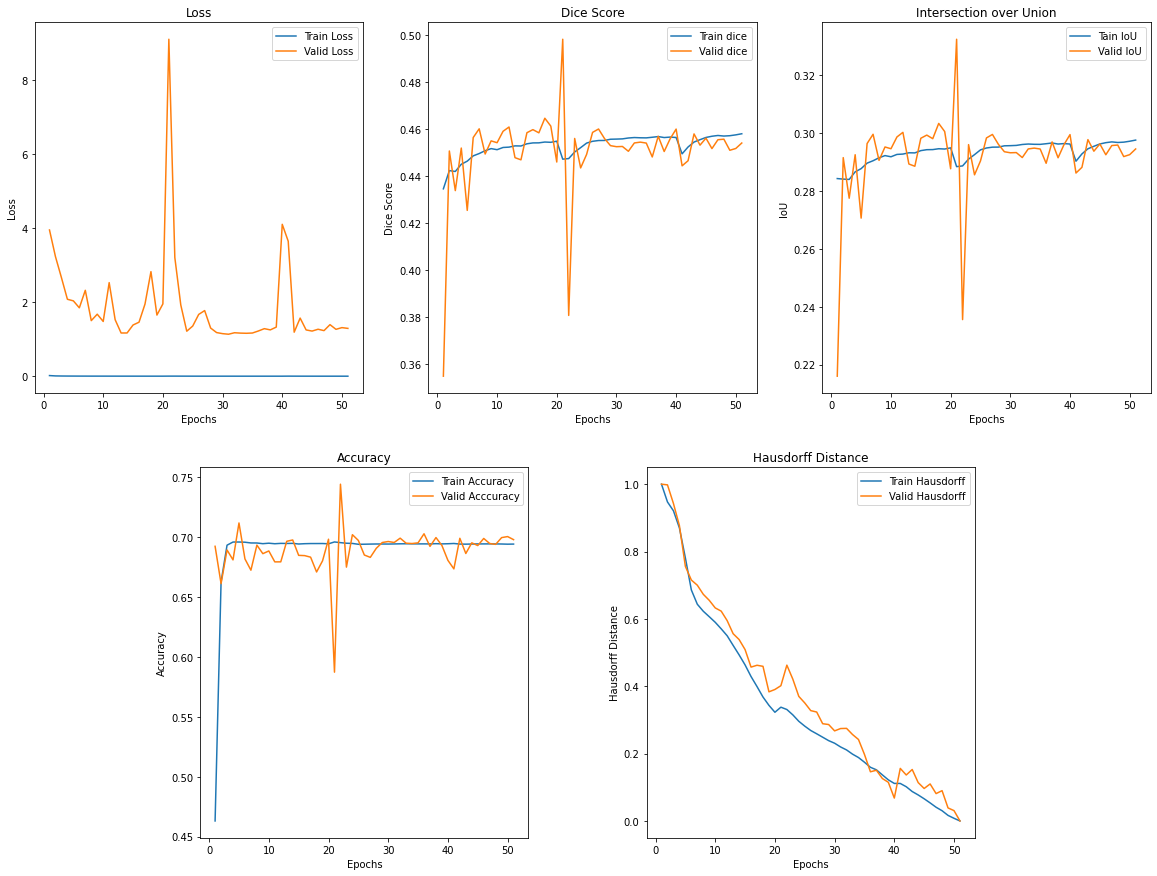

In [45]:
fig,axs = plt.subplots(2,3, figsize=(20,15))
axs[1][2].set_visible(False)

axs[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axs[1][1].set_position([0.55, 0.125, 0.228, 0.343])

axs[0,0].plot(range(1,epochs+1), train_loss_dict['loss'], label='Train Loss')
axs[0,0].plot(range(1,epochs+1), validation_loss_dict['loss'], label='Valid Loss')
axs[0,0].set_title('Loss')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].legend()
axs[0,1].plot(range(1,epochs+1), train_loss_dict['dice'], label='Train dice')
axs[0,1].plot(range(1,epochs+1), validation_loss_dict['dice'], label='Valid dice')
axs[0,1].set_title('Dice Score')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Dice Score')
axs[0,1].legend()
axs[0,2].plot(range(1,epochs+1), train_loss_dict['iou'], label='Tain IoU')
axs[0,2].plot(range(1,epochs+1), validation_loss_dict['iou'], label='Valid IoU')
axs[0,2].set_title('Intersection over Union')
axs[0,2].set_xlabel('Epochs')
axs[0,2].set_ylabel('IoU')
axs[0,2].legend()
axs[1,0].plot(range(1,epochs+1), train_loss_dict['accuracy'], label='Train Accuracy')
axs[1,0].plot(range(1,epochs+1), validation_loss_dict['accuracy'], label='Valid Acccuracy')
axs[1,0].set_title('Accuracy')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].legend()
axs[1,1].plot(range(1,epochs+1), train_loss_dict['hausdorf'], label='Train Hausdorff')
axs[1,1].plot(range(1,epochs+1), validation_loss_dict['hausdorf'], label='Valid Hausdorff')
axs[1,1].set_title('Hausdorff Distance')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Hausdorff Distance')
axs[1,1].legend()

Both dice and IoU are maximum after two epochs and later are gradually standardized with a mean of 0.3. The accuracy has been good with atleast 0.65 in almost all the epochs. 

In [46]:
train_metrics_binary = pd.DataFrame(columns=['loss', 'dice', 'accuracy', 'iou', 'hausdorf'])
train_metrics_binary['loss'] = train_loss_dict['loss']
train_metrics_binary['dice'] = train_loss_dict['dice']
train_metrics_binary['accuracy'] = train_loss_dict['accuracy']
train_metrics_binary['iou'] = train_loss_dict['iou']
train_metrics_binary['hausdorf'] = train_loss_dict['hausdorf']

valid_metrics_binary = pd.DataFrame(columns=['loss', 'dice', 'accuracy', 'iou', 'hausdorf'])
valid_metrics_binary['loss'] = validation_loss_dict['loss']
valid_metrics_binary['dice'] = validation_loss_dict['dice']
valid_metrics_binary['accuracy'] = validation_loss_dict['accuracy']
valid_metrics_binary['iou'] = validation_loss_dict['iou']
valid_metrics_binary['hausdorf'] = validation_loss_dict['hausdorf']


train_metrics_binary.to_excel("./eval_tables/train_metrics_binary.xlsx", index=False)
valid_metrics_binary.to_excel("./eval_tables/valid_metrics_binary.xlsx", index=False)

#### Extracting mask predictions and plots

In this section, I have used the same validation images and extracted the mask predictions. The predictions are then plotted to compare with the ground truth masks. This is done for several epochs.

In [47]:
# pred_mask.shape, mask.shape,
image.size(), mask.size()

(torch.Size([1, 256, 256]), torch.Size([256, 256]))

<Figure size 1080x576 with 0 Axes>

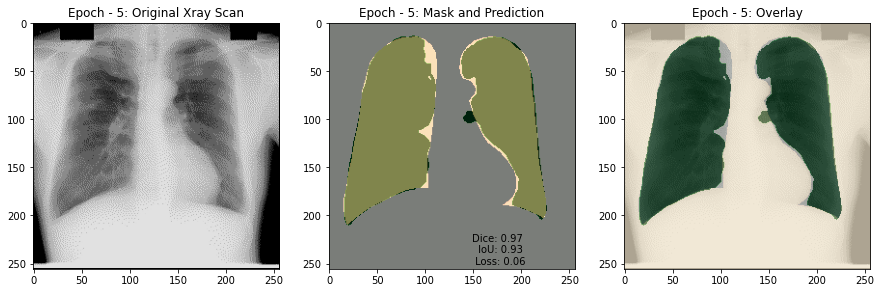

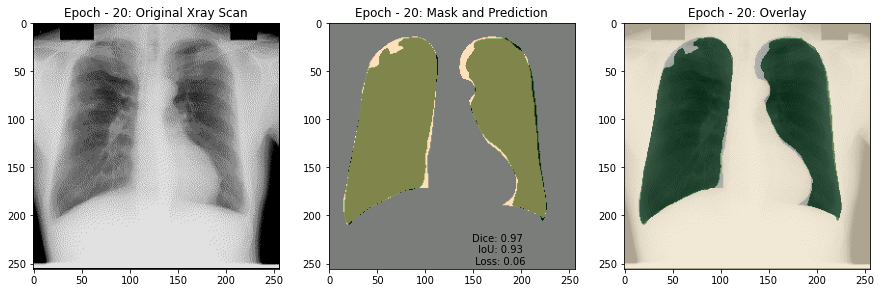

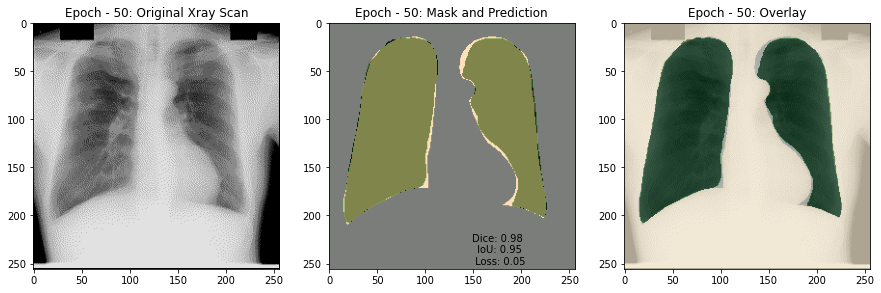

In [61]:
# idx = 22
save_models_path = 'model_ckpts_binary/'
idx = np.random.randint(0, len(datasets["valid"]))
dataloaders = torch.utils.data.DataLoader(datasets['valid'][idx], batch_size=1)

image_mask = {i: load for i, load in enumerate(iter(dataloaders))}
image, mask = image_mask[0], image_mask[1]

plt.figure(figsize=(15, 8))
epochs = [5, 20, 50]

for epoch in epochs:
    image = image.to(device)
    mask = mask.to(device)
    model_name = f'model_{epoch}_epochs_trained.pt'
    model = PretrainedUNet(1,2,True, 'bilinear')
    model.load_state_dict(torch.load(save_models_path + model_name, 
                                    map_location=torch.device("cpu")))
    model.to(device)
    model.eval()

    with torch.no_grad():
        pred_mask = model(image)
        softmax = torch.nn.functional.log_softmax(pred_mask, dim=1)
        v_loss = torch.nn.functional.nll_loss(softmax, mask).item()
        pred_mask = torch.argmax(softmax, dim=1)

        image = image.cpu()
        pred_mask = pred_mask.cpu()
        mask = mask.cpu()

        gt = np.array(mask, dtype=int)
        pred = np.array(pred_mask, dtype=int)

        pil_image = torchvision.transforms.functional.to_pil_image(image[0] + 0.5).convert("RGB")
        pil_mask = torchvision.transforms.functional.to_pil_image(mask.float()).convert("L")
        pil_pred_mask = torchvision.transforms.functional.to_pil_image(pred_mask.float()).convert("L")
        fig, ax = plt.subplots(1,3, figsize=(15,8))
        ax[0].imshow(pil_image, cmap=plt.bone())
        ax[0].set_title(f"Epoch - {epoch}: Original Xray Scan")
        ax[1].imshow(pil_mask, cmap='copper')
        ax[1].imshow(pil_pred_mask, cmap='Greens', alpha=0.5)
        ax[1].set_title(f"Epoch - {epoch}: Mask and Prediction")
        ax[2].imshow(pil_image, cmap = plt.bone())
        ax[2].imshow(pil_mask, cmap = 'copper_r', alpha=0.4)
        ax[2].imshow(pil_pred_mask, cmap='Greens', alpha=0.5)
        ax[2].set_title(f"Epoch - {epoch}: Overlay")
        evaluate = EvaluateImageSegmentation(gt, pred)
        scores_text1 = f"Dice: {round(evaluate.dice(),2)} \n IoU: {round(evaluate.IoU(),2)} \n"
        scores_text2 = f" Loss: {round(v_loss,2)}" # Accuracy:{round(evaluate.accuracy(),2)}
        ax[1].text(0.80, 0.01, scores_text1 + scores_text2,
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax[1].transAxes,
        color='black', fontsize=10)


Just like in the multi class, we could see that the predictions are good after 5 epochs. The predictions gradually imporved and after 30 epochs, However, we couldn't see much improvement from 20 epochs to 50. It looks mostly the same with similar dice, IoU and loss. 

Please note that the left lung and the right lung are single class.

In [49]:
torch.unique(pred_mask)

tensor([0, 1])

## Test Image

The models are then tested on the Gaze example Xray report and here are the results. 

In [50]:
test_image_path = "/content/drive/MyDrive/UCPHTasks/Task1-Segmentation/data/test.png"
test_img = Image.open(test_image_path).convert("P")
test_img = torchvision.transforms.functional.to_tensor(test_img) - 0.5

<Figure size 1080x576 with 0 Axes>

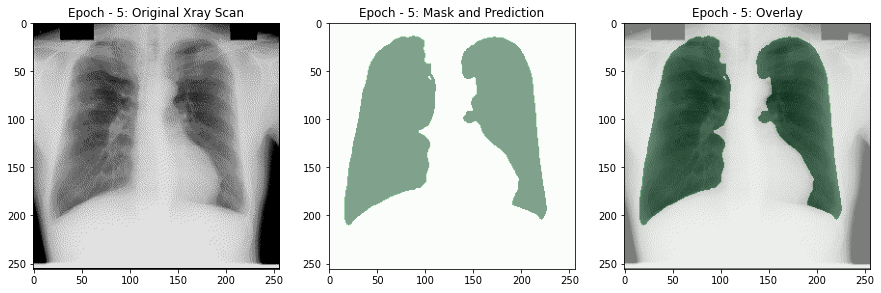

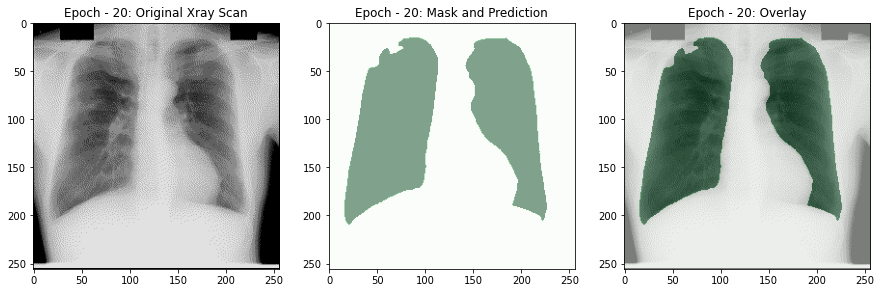

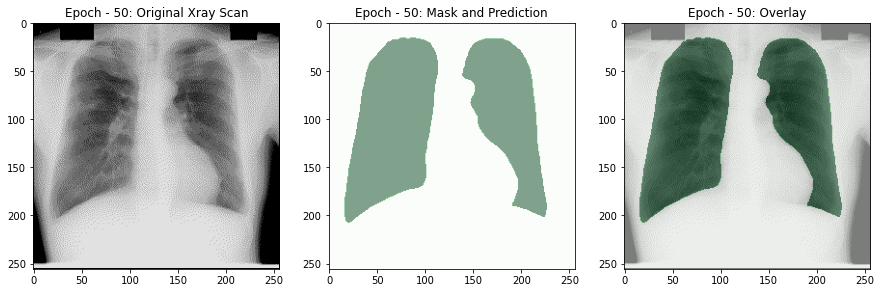

In [62]:
# # idx = 22
save_models_path = 'model_ckpts_binary/'
plt.figure(figsize=(15, 8))
epochs = [5, 20, 50]

for epoch in epochs:
    image = image.to(device)
    mask = mask.to(device)
    model_name = f'model_{epoch}_epochs_trained.pt'
    model = PretrainedUNet(1,2,True, 'bilinear')
    model.load_state_dict(torch.load(save_models_path + model_name, 
                                    map_location=torch.device("cpu")))
    model.to(device)
    model.eval()

    with torch.no_grad():
        pred_mask = model(image)
        softmax = torch.nn.functional.log_softmax(pred_mask, dim=1)
        v_loss = torch.nn.functional.nll_loss(softmax, mask).item()
        pred_mask = torch.argmax(softmax, dim=1)

        image = image.cpu()
        pred_mask = pred_mask.cpu()

        pil_image = torchvision.transforms.functional.to_pil_image(image[0] + 0.5).convert("RGB")
        pil_pred_mask = torchvision.transforms.functional.to_pil_image(pred_mask.float()).convert("L")
        fig, ax = plt.subplots(1,3, figsize=(15,8))
        ax[0].imshow(pil_image, cmap=plt.bone())
        ax[0].set_title(f"Epoch - {epoch}: Original Xray Scan")
        ax[1].imshow(pil_pred_mask, cmap='Greens', alpha=0.5)
        ax[1].set_title(f"Epoch - {epoch}: Mask and Prediction")
        ax[2].imshow(pil_image, cmap = plt.bone())
        ax[2].imshow(pil_pred_mask, cmap='Greens', alpha=0.5)
        ax[2].set_title(f"Epoch - {epoch}: Overlay")

The mask on the Gaze example image looks great and the maks it has generated perfectly fits the lungs. The model was able to learn the the pixels well and after 50 epochs, we were able to generate the best mask. 


## Comparison

I would like to compare the two binary and multi class models and see which one performed better. 

In [76]:
metrics = ['loss', 'dice', 'iou', 'accuracy']
VM_multi = pd.read_excel("./eval_tables/valid_metrics_multi.xlsx")
VM_binary = pd.read_excel("./eval_tables/valid_metrics_binary.xlsx")
for m in metrics:
    if m == 'loss':
        print(f"Best loss in Multi class model: {round(VM_multi[m].min(),4)} at {VM_multi.loc[VM_multi[m] == VM_multi[m].min()].index[0]} epoch")
        print(f"Best loss in Binary class model: {round(VM_binary[m].min(),4)} at {VM_binary.loc[VM_binary[m] == VM_binary[m].min()].index[0]} epoch")
        print(f"Average loss in Multi class model: {round(VM_multi[m].mean(),4)}")
        print(f"Average loss in Binary class model: {round(VM_binary[m].mean(),4)}")
    else:
        print(f"Best {m} in Multi class model: {round(VM_multi[m].max(),4)} at {VM_multi.loc[VM_multi[m] == VM_multi[m].max()].index[0]} epoch")
        print(f"Best {m} in Binary class model: {round(VM_binary[m].max(),4)} at {VM_binary.loc[VM_binary[m] == VM_binary[m].max()].index[0]} epoch")
        print(f"Average {m} in Multi class model: {round(VM_multi[m].mean(),4)}")
        print(f"Average {m} in Binary class model: {round(VM_binary[m].mean(),4)}")


Best loss in Multi class model: 1.0767 at 25 epoch
Best loss in Binary class model: 1.134 at 30 epoch
Average loss in Multi class model: 2.358
Average loss in Binary class model: 1.8798
Best dice in Multi class model: 0.5884 at 0 epoch
Best dice in Binary class model: 0.4981 at 20 epoch
Average dice in Multi class model: 0.4557
Average dice in Binary class model: 0.4504
Best iou in Multi class model: 0.4169 at 0 epoch
Best iou in Binary class model: 0.3325 at 20 epoch
Average iou in Multi class model: 0.2969
Average iou in Binary class model: 0.2917
Best accuracy in Multi class model: 0.7926 at 2 epoch
Best accuracy in Binary class model: 0.7443 at 21 epoch
Average accuracy in Multi class model: 0.6798
Average accuracy in Binary class model: 0.6893


The loss of multi class model has converged faster and is less than the binary model. However, the accuracy, IoU and dice scores are turned to be lower after 3 epochs for multi class model. It is probabily. Also, the average accuracy achieved by both the models are mostly same with slight variation. Overall, although the predicted masks seem promising, it still needs more iterations.

If you are looking for a model that could do individual segmentations of lungs, we could use the multi class model right away. 